In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import joblib
import shutil

from keras.models import load_model

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/lfw-deepfunneled/'

# Functions

In [ ]:
def preprocess(img):
  clf = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  
  gray = np.array(img, dtype='uint8')
  faces = clf.detectMultiScale(gray, 1.3, 3)
  
  cropped_img = None
  for (x, y, w, h) in faces:
    cropped_img = img[y:y+h,x:x+w]

  # use the center of the image if failed to detect faces
  if cropped_img is None:
    cropped_img = cv2.resize(img[61:189,61:189], (160,160))
  return cv2.resize(cropped_img, (160,160))

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.3):    
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]    
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis=-1)
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
  basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
  loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
  return loss

In [ ]:
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  
  mean = face_pixels.mean()                    
  std  = face_pixels.std()                     
  face_pixels = (face_pixels - mean)/std       
  samples = np.expand_dims(face_pixels,axis=0)     
  yhat = model.predict(samples)
  return yhat[0]

# Base Dataset

In [ ]:
save_dir = '/content/drive/MyDrive/lfw_resized/'

In [ ]:
#save preprocessed images for ease of future use
total_size = 13233
datagen = ImageDataGenerator(preprocessing_function=preprocess, rescale=1./255).flow_from_directory(path, target_size=(160, 160), batch_size=total_size)
x_batch, y_batch = datagen.next()
labels = list(datagen.class_indices.keys())
for i in range(total_size):
  image = x_batch[i]
  label = labels[np.argmax(y_batch[i])]
  save_path = os.path.join(save_dir + label)
  os.makedirs(save_path, exist_ok=True)
  os.chdir(save_path)
  filename = str(i) + '.jpg'
  cv2.imwrite(filename, cv2.cvtColor(255*image, cv2.COLOR_RGB2BGR))

Found 13233 images belonging to 5749 classes.


In [ ]:
#Set up generators
#One for training and one for testing
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_gen = datagen.flow_from_directory(save_dir, subset='training', target_size=(160, 160), batch_size=12161)
test_gen = datagen.flow_from_directory(save_dir, subset='validation', target_size=(160, 160), batch_size=1072)

Found 12161 images belonging to 5749 classes.
Found 1072 images belonging to 5749 classes.


In [ ]:
#for x_batch_train, y_batch_train in train_gen.next():
x_batch_train, y_batch_train = train_gen.next()
x_batch_test, y_batch_test = test_gen.next()

Jim_Furyk


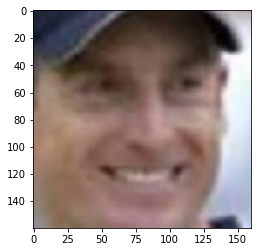

Jayson_Williams


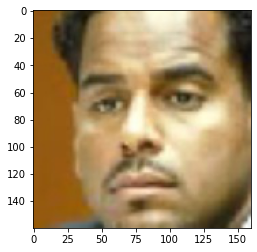

In [ ]:
labels = list(train_gen.class_indices.keys())
for i in range (0,2):
    image = x_batch_train[i]
    #print(np.argmax(y_batch_train[i]))
    print(labels[np.argmax(y_batch_train[i])])
    plt.imshow(image)
    plt.show()

In [ ]:
net = load_model('/content/drive/MyDrive/facenet_keras.h5') #use facenet model to create embeddings

In [ ]:
net.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [ ]:
train_image_embeddings = []
for image in x_batch_train:
  train_image_embeddings.append(extract_embeddings(net, image))
train_image_embeddings = np.asarray(train_image_embeddings)

test_image_embeddings = []
for image in x_batch_test:
  test_image_embeddings.append(extract_embeddings(net, image))
test_image_embeddings = np.asarray(test_image_embeddings)

In [ ]:
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(train_image_embeddings)
testX = in_encoder.transform(test_image_embeddings)

y_train = np.argmax(y_batch_train, axis=1)
y_test = np.argmax(y_batch_test, axis=1)

In [ ]:
net = LinearSVC()
net.fit(trainX, y_train)
joblib.dump(net, '/content/drive/MyDrive/facenet_lfw.pkl') #save classifier

['/content/drive/MyDrive/facenet_lfw.pkl']

In [ ]:
yhat_train = net.predict(trainX)
yhat_test = net.predict(testX)

In [ ]:
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
print('Dataset: train = %d, test = %d' % (trainX.shape[0], testX.shape[0]))
print('Accuracy: train = %.3f, test = %.3f' % (score_train*100, score_test*100))

Dataset: train = 12161, test = 1072
Accuracy: train = 99.326, test = 96.269


# Masked dataset testing

In [ ]:
masked_gen = ImageDataGenerator(rescale=1./255) #images already cropped to faces, so no preprocessing
masked_test = mixed_gen.flow_from_directory(directory='/content/drive/MyDrive/lfw_masked/lfw_test', target_size=(160, 160))

Found 90 images belonging to 48 classes.


In [ ]:
masked_x_batch_test, masked_y_batch_test = masked_test.next()

In [ ]:
net = load_model('/content/drive/MyDrive/facenet_keras.h5')
net.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [ ]:
masked_test_image_embeddings = []
for image in masked_x_batch_test:
  masked_test_image_embeddings.append(extract_embeddings(net, image))
masked_test_image_embeddings = np.asarray(masked_test_image_embeddings)

in_encoder = Normalizer(norm='l2')
masked_testX = in_encoder.transform(masked_test_image_embeddings)
masked_y_test = np.argmax(masked_y_batch_test, axis=1)

In [ ]:
net = joblib.load('/content/drive/MyDrive/facenet_lfw.pkl') #load classifier

In [ ]:
mixed_yhat_test = net.predict(mixed_testX)

In [ ]:
score_test = accuracy_score(mixed_y_test, mixed_yhat_test)
print('Accuracy: test = %.3f' % (score_test*100))

Accuracy: test = 0.000
